<a href="https://colab.research.google.com/github/cmap/lincs-workshop-2020/blob/main/notebooks/gene_expression/Exercise_2_Compound_dose_response.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dose Response Example

### *Andrew Yang*

The goal of this exercise is to try to assess the different types of dose behavior we observe in L1000 data. As a case study, we'll be using signatures of ~1,500 compounds profiled at 6-point dose across multiple cell lines. It is worth noting that the previous version of the CMap L1000 resource was mostly done at 1 dose, but the recent expansion includes thousands of compounds profiled at dose.

# Setup, read in data

We'll obtain the data using the cmapBQ toolkit, demonstrated in an separate notebook. The steps below will install and configure the toolkit so that we can retrieve the signature metadata of interest.

In [1]:
!pip -q install cmapBQ

     |████████████████████████████████| 153kB 6.9MB/s 


In [2]:
import requests

# URL with credentials
url = ('https://s3.amazonaws.com/data.clue.io/api/bq_creds/BQ-demo-credentials.json')

response = requests.get(url)
credentials_filepath='/content/BQ-demo-credentials.json'

with open(credentials_filepath, 'w') as f:
  f.write(response.text)

In [3]:
import cmapBQ.query as cmap_query
import cmapBQ.config as cmap_config

# Set up credentials
cmap_config.setup_credentials(credentials_filepath)
bq_client = cmap_config.get_bq_client()

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from __future__ import division
% matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

For simplicity, the data we'll use here is will meet the following criteria:
* 24H
* most common dose series: 10 uM -> 40 nM in 3-fold dilutions

In [77]:
sql = """
SELECT sig_id, pert_id, cmap_name, pert_dose, pert_idose,
pert_itime, cell_iname, nsample, tas FROM
cmap-big-table.cmap_lincs_public_views.siginfo WHERE
sig_id like 'REP.A%' AND
pert_type = 'trt_cp' AND
nsample > 1 AND
pert_itime = '24 h'
"""

In [78]:
siginfo = cmap_query.run_query(query=sql, client=bq_client).result().to_dataframe()

In [79]:
siginfo.head()

,sig_id,pert_id,cmap_name,pert_dose,pert_idose,pert_itime,cell_iname,nsample,tas
0,REP.A020_MDAMB231_24H:M02,BRD-K47000838,BRD-K47000838,1.390020,1.25 uM,24 h,MDAMB231,2,0.355488
1,REP.A001_MCF7_24H:P22,BRD-K03842655,penitrem-a,0.074074,0.07 uM,24 h,MCF7,3,0.098558
2,REP.A006_HELA_24H:K16,BRD-A22380646,pantoprazole,0.372207,0.37 uM,24 h,HELA,3,0.145182
3,REP.A010_HELA_24H:M19,BRD-K15170068,swainsonine,11.546700,12 uM,24 h,HELA,3,0.177815
4,REP.A020_HT29_24H:M02,BRD-K47000838,BRD-K47000838,1.390020,1.25 uM,24 h,HT29,3,0.166098


In [80]:
# count the number of occurrences at each dose
siginfo.pert_idose.value_counts()

0.04 uM     16820
0.37 uM     16769
1.11 uM     16759
3.33 uM     16747
0.125 uM    16671
10 uM       16578
20 uM        5772
0.12 uM        81
0.3 uM         68
0.01 uM        66
4 uM           64
0.004 uM       57
1.25 uM        53
0.05 uM        40
0.02 uM        38
0.5 uM         38
1.67 uM        36
12 uM          25
0.2 uM         24
6.66 uM        24
0.06 uM        24
0.74 uM        23
0.03 uM        23
0.07 uM        21
0.025 uM       21
2.22 uM        21
0.22 uM        21
0.66 uM        21
0.08 uM        12
0.25 uM        12
8 uM           11
2.5 uM         11
Name: pert_idose, dtype: int64

That looks pretty decent but there are some signatures that don't fall within the expected dose range. We can clean that up by restricting to a specific list of doses.

In [81]:
# what are the allowed doses
allowed_doses = ['0.04 uM', '0.125 uM', '0.37 uM', '1.11 uM', '3.33 uM', '10 uM']

In [82]:
siginfo = siginfo[siginfo.pert_idose.isin(allowed_doses)]
siginfo.pert_idose.value_counts()

0.04 uM     16820
0.37 uM     16769
1.11 uM     16759
3.33 uM     16747
0.125 uM    16671
10 uM       16578
Name: pert_idose, dtype: int64

In [83]:
# and let's make sure we have 3 replicates for each signature
foo = siginfo[siginfo.nsample == 3]

# Let's take a look at the data

How many total signatures are we working with?

In [84]:
len(siginfo)

100344

How many compounds?

In [85]:
cp_list = siginfo["cmap_name"].unique()
len(cp_list)

1561

Signatures per cell line?

In [86]:
siginfo["cell_iname"].value_counts()

MCF7        9288
HT29        9277
A375        8949
HA1E        8933
PC3         8925
YAPC        8924
HELA        8609
A549        7589
MCF10A      6565
HEK293      5902
MDAMB231    5261
THP1        4883
JURKAT      4241
XC.L10      1667
HUVEC       1331
Name: cell_iname, dtype: int64

In [87]:
siginfo.nsample.value_counts()

3    77335
2    23009
Name: nsample, dtype: int64

# Global Trends

Let's start by seeing if we see a dose response in TAS, even when aggregated across compounds and cell lines.

We would expect increasing TAS with increasing dose:

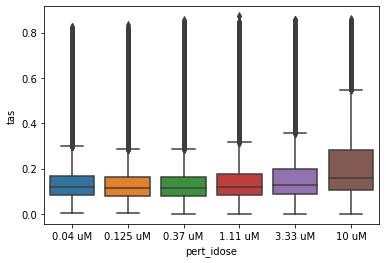

In [88]:
sns.boxplot(x="pert_idose",
            y="tas",
            data=siginfo,
            order=allowed_doses);

What if we split by cell line?

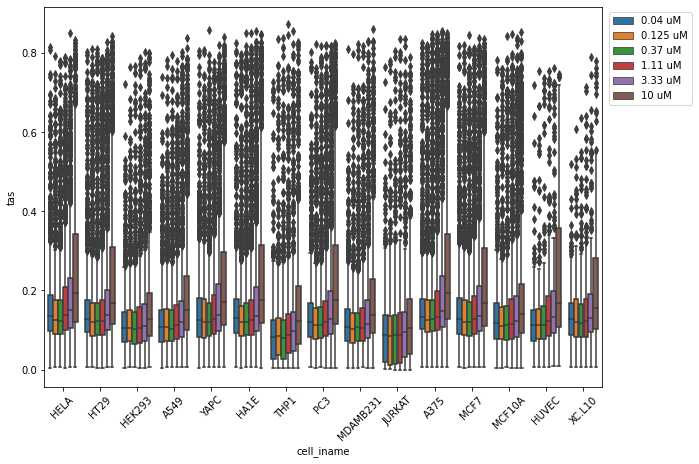

In [89]:
f, ax = plt.subplots(figsize=(10,7))
sns.boxplot(x="cell_iname",
            y="tas",
            hue="pert_idose",
            data=siginfo,
            hue_order=allowed_doses)
plt.legend(bbox_to_anchor=(1.17,1), loc="upper right");
plt.xticks(rotation=45);

# Per compound

Now we'll take a look at dose response at the compound level. Let's keep things aggregated by cell line for now.

Let's take a look at a few compounds that might fall into some categories

### Dose-responsive: AZD-5438

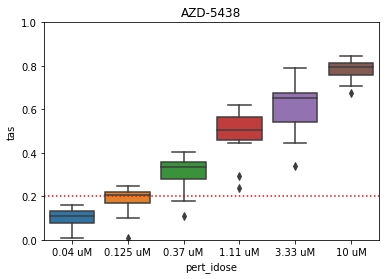

In [90]:
cp = "AZD-5438"
cp_subset = siginfo[siginfo["cmap_name"] == cp]

f,ax = plt.subplots()
sns.boxplot(x="pert_idose",
            y="tas",
            data=cp_subset,
            order=allowed_doses);
plt.title(cp);
plt.ylim(0,1);
ax.axhline(0.2, color="red", linestyle="dotted");

### Saturated: bortezomib

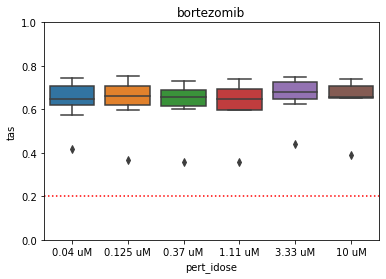

In [67]:
cp = "bortezomib"
cp_subset = siginfo[siginfo["cmap_name"] == cp]

f,ax = plt.subplots()
sns.boxplot(x="pert_idose",
            y="tas",
            data=cp_subset,
            order=allowed_doses);
plt.title(cp);
plt.ylim(0,1);
ax.axhline(0.2, color="red", linestyle="dotted");

### Inert: ibudilast

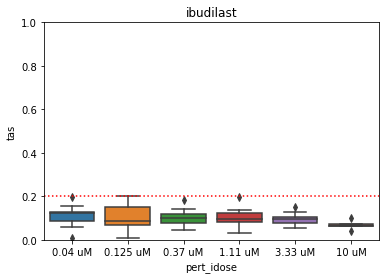

In [68]:
cp = "ibudilast"
cp_subset = siginfo[siginfo["cmap_name"] == cp]

f,ax = plt.subplots()
sns.boxplot(x="pert_idose",
            y="tas",
            data=cp_subset,
            order=allowed_doses);
plt.title(cp);
plt.ylim(0,1);
ax.axhline(0.2, color="red", linestyle="dotted");

# Per compound, cell line

For some compounds, it looks like we can get at how dose-responsive they are even when aggregated across cell lines. But by aggregating, we won't see activity differences by cell line.

So let's take a deeper, unaggregated look at those compounds from above.

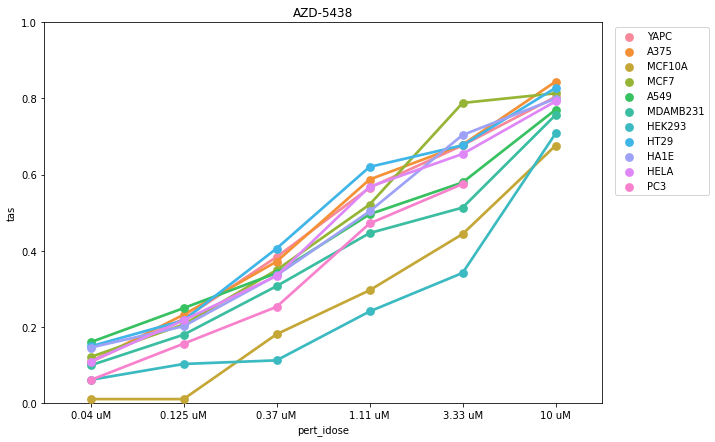

In [73]:
cp = "AZD-5438"
cp_subset = siginfo[siginfo["cmap_name"] == cp].dropna(subset=["tas"])

f, ax = plt.subplots(figsize=(10,7))
sns.pointplot(x="pert_idose",
            y="tas",
            hue="cell_iname",
            data=cp_subset,
            order=allowed_doses);
plt.title(cp);
plt.legend(bbox_to_anchor=(1.2,1), loc="upper right");
plt.ylim(0,1);

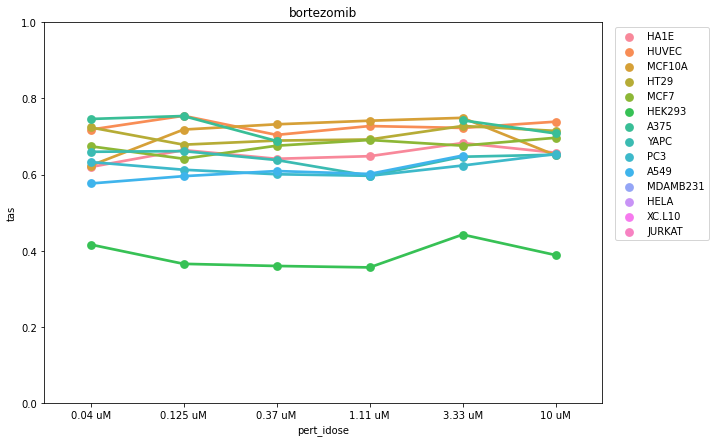

In [74]:
cp = "bortezomib"
cp_subset = siginfo[siginfo["cmap_name"] == cp].dropna(subset=["tas"])

f, ax = plt.subplots(figsize=(10,7))
sns.pointplot(x="pert_idose",
            y="tas",
            hue="cell_iname",
            data=cp_subset,
            order=allowed_doses);
plt.title(cp);
plt.legend(bbox_to_anchor=(1.2,1), loc="upper right");
plt.ylim(0,1);

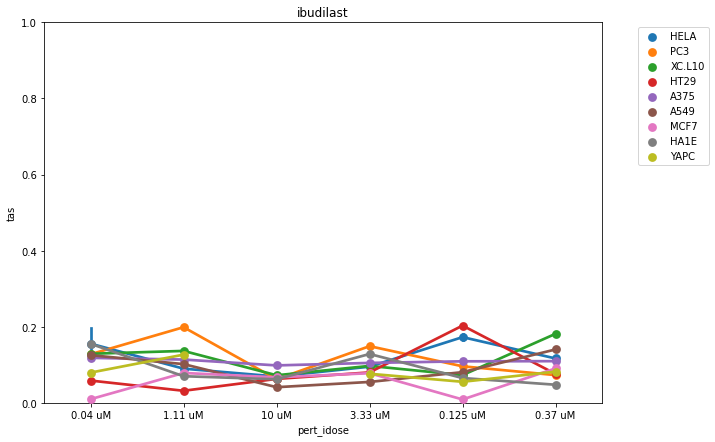

In [75]:
cp = "ibudilast"
cp_subset = siginfo[siginfo["cmap_name"] == cp].dropna(subset=["tas"])

f, ax = plt.subplots(figsize=(10,7))
sns.pointplot(x="pert_idose",
            y="tas",
            hue="cell_iname",
            data=cp_subset,
            order=dose_series);
plt.title(cp);
plt.legend(bbox_to_anchor=(1.2,1), loc="upper right");
plt.ylim(0,1);

# Quantifying dose response

The above examples were hand-picked, but what if we wanted to systematically categorize compound-cell pairs? How about slope of TAS against dose?

Let's get unique compound-cell line pairs

In [76]:
cp_cell_pairs = list({tuple(row) for row in siginfo[["cmap_name", "cell_iname"]].values})

Now let's compute a linear regression (TAS against log3 dose) for each compound-cell line pair.

The linear regression for each compound-cell pair takes about 5 minutes and the code is below. But for time's sake let's just read in the results.

In [93]:
cp_cell_metrics = pd.DataFrame(columns=["cmap_name",
                                        "cell_iname",
                                        "min_tas",
                                        "q25_tas",
                                        "median_tas",
                                        "q75_tas",
                                        "max_tas",
                                        "is_monotonic",
                                        "sd_tas",
                                        "n_doses",
                                        "lm_slope",
                                        "lm_intercept",
                                        "lm_rvalue",
                                        "lm_pvalue",
                                        "lm_stderr"])

i = 0
for cp_cell_pair in sorted(cp_cell_pairs):
    cp, cell = cp_cell_pair
    cp_cell_subset = siginfo[(siginfo["cmap_name"] == cp) &
                             (siginfo["cell_iname"] == cell)]
    # let's drop sigs with missing TAS (singlicates), and sort.
    cp_cell_subset = cp_cell_subset.dropna(subset=["tas"]).sort_values(["pert_dose"])
    
    # skip if we don't have enough points to calculate slope
    if len(cp_cell_subset["tas"]) < 2:
        continue

    tas_per_dose = cp_cell_subset["tas"]
    doses = cp_cell_subset["pert_dose"].values
    # log3 because doses are 3-fold dilution
    log3_doses = np.log(doses) / np.log(3)
    
    min_tas = tas_per_dose.min()
    q25_tas = tas_per_dose.quantile(0.25)
    median_tas = tas_per_dose.median()
    q75_tas = tas_per_dose.quantile(0.75)
    max_tas = tas_per_dose.max()
    is_monotonic = tas_per_dose.is_monotonic
    sd_tas = tas_per_dose.std()
    n_doses = len(doses)
    
    linregress_results = stats.linregress(log3_doses, tas_per_dose)
    slope = linregress_results.slope
    intercept = linregress_results.intercept
    rvalue = linregress_results.rvalue
    pvalue = linregress_results.pvalue
    stderr = linregress_results.stderr
    
    row = [cp, cell, min_tas, q25_tas, median_tas, q75_tas, max_tas, is_monotonic, sd_tas, n_doses,
           slope, intercept, rvalue, pvalue, stderr]
    cp_cell_metrics.loc[i] = row
    i += 1

In [95]:
# take a look at the first few rows
cp_cell_metrics.head()

,cmap_name,cell_iname,min_tas,q25_tas,median_tas,q75_tas,max_tas,is_monotonic,sd_tas,n_doses,lm_slope,lm_intercept,lm_rvalue,lm_pvalue,lm_stderr
0,10-DEBC,A375,0.250336,0.265752,0.316824,0.352728,0.431502,False,0.068878,6,0.031353,0.334155,0.851583,0.031407,0.009650
1,10-DEBC,HA1E,0.080418,0.089374,0.109198,0.126371,0.346345,False,0.101317,6,0.037465,0.158476,0.691802,0.127842,0.019553
2,10-DEBC,HELA,0.075567,0.094545,0.104848,0.141841,0.195790,False,0.044830,6,0.004421,0.122842,0.184478,0.726423,0.011776
3,10-DEBC,HT29,0.090235,0.109422,0.150441,0.203087,0.291498,False,0.076508,6,0.025020,0.176610,0.611798,0.196800,0.016174
4,10-DEBC,MCF7,0.109670,0.139026,0.141311,0.170481,0.260272,False,0.053134,6,-0.000593,0.161599,-0.020897,0.968660,0.014197


In [ ]:
cp_cell_metrics["range_tas"] = cp_cell_metrics["max_tas"] - cp_cell_metrics["min_tas"]
cp_cell_metrics["lm_rsquared"] = cp_cell_metrics["lm_rvalue"]**2

Here we'll just read the precomputed results.

In [159]:
# download the pre-computed linear regression results
!wget --quiet -O - https://s3.amazonaws.com/repo-assets.clue.io/cp_cell_linregress_metrics.txt.gz | gunzip > cp_cell_linregress_metrics.txt

In [161]:
cp_cell_metrics = pd.read_csv('cp_cell_linregress_metrics.txt', sep='\t', na_values='-666')

In [162]:
cp_cell_metrics.head()

,cmap_name,brew_prefix,cell_iname,min_tas,q25_tas,median_tas,q75_tas,max_tas,is_monotonic,sd_tas,n_doses,lm_slope,lm_intercept,lm_rvalue,lm_pvalue,lm_stderr,range_tas,lm_rsquared,category
0,MLN-2238,REP.A024_JURKAT_24H,JURKAT,0.067137,0.148203,0.387222,0.794329,0.833469,True,0.356069,5,0.216811,0.642839,0.966413,0.007352,0.033288,0.766332,0.933954,dose-responsive-strong
1,tioguanine,REP.A025_A375_24H,A375,0.110061,0.285966,0.640109,0.763379,0.791588,True,0.304231,5,0.184405,0.500219,0.956219,0.010924,0.032584,0.681527,0.914354,dose-responsive-strong
2,alvocidib,REP.A026_HT29_24H,HT29,0.146678,0.212222,0.584040,0.759094,0.792575,True,0.303084,5,0.183003,0.665006,0.958320,0.010151,0.031499,0.645897,0.918377,dose-responsive-strong
3,midostaurin,REP.A010_MCF7_24H,MCF7,0.008215,0.122264,0.301485,0.795651,0.797814,False,0.372493,5,0.177832,0.424614,0.922777,0.025460,0.042874,0.789599,0.851517,dose-responsive-strong
4,meisoindigo,REP.A010_PC3_24H,PC3,0.147486,0.158343,0.235921,0.791956,0.792333,False,0.336698,5,0.174497,0.583573,0.822553,0.087302,0.069653,0.644847,0.676594,other


# code to compute linear regression (runtime ~5 min)

cp_cell_metrics = pd.DataFrame(columns=["pert_iname",
                                        "cell_id",
                                        "min_tas",
                                        "q25_tas",
                                        "median_tas",
                                        "q75_tas",
                                        "max_tas",
                                        "is_monotonic",
                                        "sd_tas",
                                        "n_doses",
                                        "lm_slope",
                                        "lm_intercept",
                                        "lm_rvalue",
                                        "lm_pvalue",
                                        "lm_stderr"])

i = 0
for cp_cell_pair in sorted(cp_cell_pairs):
    cp, cell = cp_cell_pair
    cp_cell_subset = siginfo[(siginfo["pert_iname"] == cp) &
                             (siginfo["cell_id"] == cell)]
    # let's drop sigs with missing TAS (singlicates), and sort.
    cp_cell_subset = cp_cell_subset.dropna(subset=["distil_tas"]).sort_values(["pert_dose"])
    
    # skip if we don't have enough points to calculate slope
    if len(cp_cell_subset["distil_tas"]) < 2:
        continue

    tas_per_dose = cp_cell_subset["distil_tas"]
    doses = cp_cell_subset["pert_dose"].values
    # log3 because doses are 3-fold dilution
    log3_doses = np.log(doses) / np.log(3)
    
    min_tas = tas_per_dose.min()
    q25_tas = tas_per_dose.quantile(0.25)
    median_tas = tas_per_dose.median()
    q75_tas = tas_per_dose.quantile(0.75)
    max_tas = tas_per_dose.max()
    is_monotonic = tas_per_dose.is_monotonic
    sd_tas = tas_per_dose.std()
    n_doses = len(doses)
    
    linregress_results = stats.linregress(log3_doses, tas_per_dose)
    slope = linregress_results.slope
    intercept = linregress_results.intercept
    rvalue = linregress_results.rvalue
    pvalue = linregress_results.pvalue
    stderr = linregress_results.stderr
    
    row = [cp, cell, min_tas, q25_tas, median_tas, q75_tas, max_tas, is_monotonic, sd_tas, n_doses,
           slope, intercept, rvalue, pvalue, stderr]
    cp_cell_metrics.loc[i] = row
    i += 1

How many compound-cell line pairs?

In [136]:
n_cp_cell_pairs = len(cp_cell_metrics)
n_cp_cell_pairs

12936

How many pairs are we left with if we want only those pairs where we have data in at least 5 doses? We want to make sure our slope metric is robust.

In [135]:
(cp_cell_metrics["n_doses"] >= 5).sum()

12936

That's not bad-- let's subset to just those.

In [137]:
cp_cell_metrics = cp_cell_metrics[cp_cell_metrics["n_doses"] >= 5]

## Let's take a look at the compound-cell pair with the highest slope.

In [138]:
cp_cell_metrics.sort_values(["lm_slope"], ascending=False).head(5)

,pert_iname,brew_prefix,cell_id,min_tas,q25_tas,median_tas,q75_tas,max_tas,is_monotonic,sd_tas,n_doses,lm_slope,lm_intercept,lm_rvalue,lm_pvalue,lm_stderr,range_tas,lm_rsquared,category
0,MLN-2238,REP.A024_JURKAT_24H,JURKAT,0.067137,0.148203,0.387222,0.794329,0.833469,True,0.356069,5,0.216811,0.642839,0.966413,0.007352,0.033288,0.766332,0.933954,dose-responsive-strong
1,tioguanine,REP.A025_A375_24H,A375,0.110061,0.285966,0.640109,0.763379,0.791588,True,0.304231,5,0.184405,0.500219,0.956219,0.010924,0.032584,0.681527,0.914354,dose-responsive-strong
2,alvocidib,REP.A026_HT29_24H,HT29,0.146678,0.212222,0.584040,0.759094,0.792575,True,0.303084,5,0.183003,0.665006,0.958320,0.010151,0.031499,0.645897,0.918377,dose-responsive-strong
3,midostaurin,REP.A010_MCF7_24H,MCF7,0.008215,0.122264,0.301485,0.795651,0.797814,False,0.372493,5,0.177832,0.424614,0.922777,0.025460,0.042874,0.789599,0.851517,dose-responsive-strong
4,meisoindigo,REP.A010_PC3_24H,PC3,0.147486,0.158343,0.235921,0.791956,0.792333,False,0.336698,5,0.174497,0.583573,0.822553,0.087302,0.069653,0.644847,0.676594,other


Does it look dose-responsive?

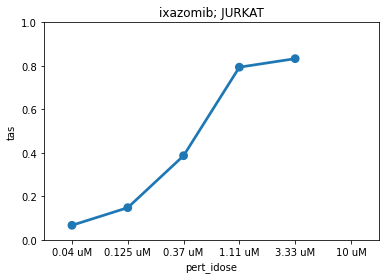

In [140]:
cp = "ixazomib" # aka MLN-2238
cell = "JURKAT"
cp_cell_subset = siginfo[(siginfo["cmap_name"] == cp) &
                         (siginfo["cell_iname"] == cell)].dropna(subset=["tas"])

# f, ax = plt.subplots(figsize=(10,7))
sns.pointplot(x="pert_idose",
            y="tas",
            data=cp_cell_subset,
            order=allowed_doses);
plt.title("{}; {}".format(cp,cell));
plt.ylim(0,1);

## What's the distribution of slopes?

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


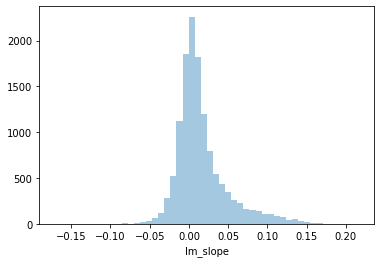

In [141]:
sns.distplot(cp_cell_metrics["lm_slope"], kde=False)

## Considering goodness of fit for dose-responsiveness

To be more conservative in our dose-responsive labeling, we might exclude situations where the slope is high, *but* $r^{2}$ < 0.7.

Let's take a look at an example:

In [142]:
cp_cell_metrics[(cp_cell_metrics["lm_slope"] > 0.15) &
                (cp_cell_metrics["lm_rsquared"] < 0.7)]

,pert_iname,brew_prefix,cell_id,min_tas,q25_tas,median_tas,q75_tas,max_tas,is_monotonic,sd_tas,n_doses,lm_slope,lm_intercept,lm_rvalue,lm_pvalue,lm_stderr,range_tas,lm_rsquared,category
4,meisoindigo,REP.A010_PC3_24H,PC3,0.147486,0.158343,0.235921,0.791956,0.792333,False,0.336698,5,0.174497,0.583573,0.822553,0.087302,0.069653,0.644847,0.676594,other


In [ ]:
siginfo[siginfo.cmap_name=='meisoindigo']

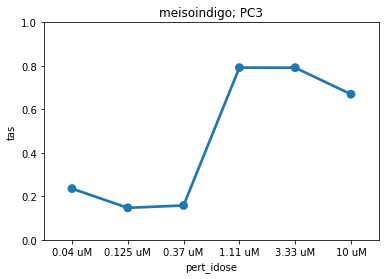

In [147]:
cp = "meisoindigo"
cell = "PC3"
cp_cell_subset = siginfo[(siginfo["cmap_name"] == cp) &
                         (siginfo["cell_iname"] == cell)].dropna(subset=["tas"])

# f, ax = plt.subplots(figsize=(10,7))
sns.pointplot(x="pert_idose",
            y="tas",
            data=cp_cell_subset,
            order=allowed_doses);
plt.title("{}; {}".format(cp,cell));
plt.ylim(0,1);

We'll want to categorize this high slope, poor fit case as "other"

Let's look at the r-squared distribution

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


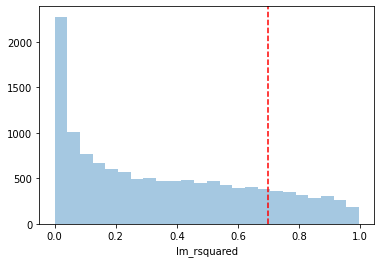

In [148]:
sns.distplot(cp_cell_metrics["lm_rsquared"], kde=False)
plt.axvline(0.7, color="red", linestyle="dashed");

This is a fairly strict fit requirement for dose-responsiveness, but for this first pass heuristic, we're just interested in being able to systematically reveal some interesting examples.

## Picking a dose-responsive slope threshold

Let's plot TAS against dose for slope bins of 0.01 from, say 0 to 0.1.

This will help us tune our heuristic for calling a compound in a cell dose-repsonsive.

In [150]:
slope_bins = [(i/100.0, (i+1)/100.0) for i in range(0,10)]
slope_bins

[(0.0, 0.01),
 (0.01, 0.02),
 (0.02, 0.03),
 (0.03, 0.04),
 (0.04, 0.05),
 (0.05, 0.06),
 (0.06, 0.07),
 (0.07, 0.08),
 (0.08, 0.09),
 (0.09, 0.1)]

Let's randomly sample 50 compound-cell pairs with a good linear fit ($r^{2}$ > 0.7) for each slope bin and take a look

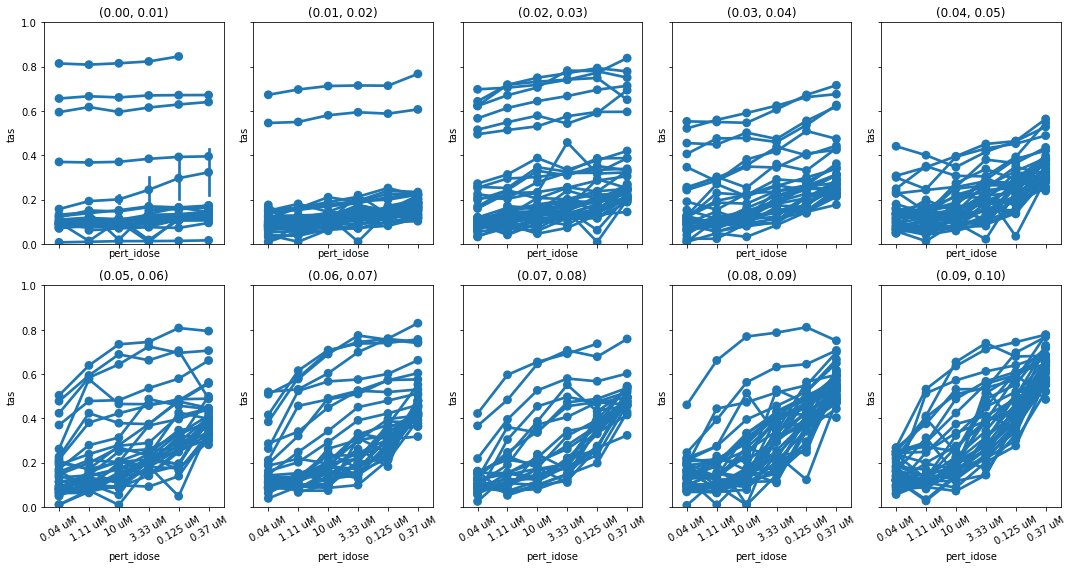

In [163]:
# set random seed so results are reproducible
np.random.seed(42)

f, ax = plt.subplots(2, 5, figsize=(15,8), sharey=True, sharex=True)
ax_list = ax.reshape(-1)
for i, slope_bin in enumerate(slope_bins):
    cp_cell_subset = cp_cell_metrics[(cp_cell_metrics["lm_slope"].between(*slope_bin)) &
                                     (cp_cell_metrics["lm_rsquared"] > 0.7)]
    # let's sample 50 cp-cell pairs, unless there are fewer
    if len(cp_cell_subset) >= 50:
        sample = cp_cell_subset.sample(50)
    else:
        sample = cp_cell_subset
    cp_cell_pairs = zip(sample["cmap_name"].values, sample["cell_iname"].values)
    siginfo_sample = pd.DataFrame()

    for pair in cp_cell_pairs:
        cp, cell = pair
        # subset signatures with current compound-cell combination
        siginfo_subset = siginfo[(siginfo["cmap_name"] == cp) &
                                 (siginfo["cell_iname"] == cell)]
        cur_ax = ax_list[i]
        sns.pointplot(x="pert_idose",
                      y="tas",
                      data=siginfo_subset,
                      order=allowed_doses,
                      ax=cur_ax);
        cur_ax.set_title("({:.2f}, {:.2f})".format(*slope_bin));
        cur_ax.set_ylim(0,1);
        cur_ax.set_xticklabels(dose_series, rotation=30);
    plt.tight_layout();

Let's define dose-responsive compound-cell pairs as those with a slope > 0.02

## Considering TAS range for low slope (defining inert/saturated)

For those with low slopes, let's wave the good fit requirement, and require a TAS range < 0.2.

In [ ]:
cp_cell_metrics[(cp_cell_metrics["lm_slope"] < 0.02) &
                (cp_cell_metrics["range_tas"] > 0.2)].head()

,pert_iname,cell_id,min_tas,q25_tas,median_tas,q75_tas,max_tas,is_monotonic,sd_tas,n_doses,lm_slope,lm_intercept,lm_rvalue,lm_pvalue,lm_stderr,range_tas,lm_rsquared
22,17-hydroxyprogesterone-caproate,YAPC,0.007634,0.131108,0.175212,0.212336,0.220211,False,0.080959,6,0.010516,0.157481,0.243017,0.642650,0.020989,0.212577,0.059057
28,"2',5'-dideoxyadenosine",PC3,0.008338,0.048564,0.068305,0.137848,0.268907,False,0.095546,6,-0.006082,0.100354,-0.119087,0.822214,0.025354,0.260569,0.014182
31,2-iminobiotin,A549,0.078974,0.109035,0.136247,0.190557,0.280131,False,0.074172,6,0.008323,0.160067,0.209931,0.689730,0.019381,0.201158,0.044071
33,2-iminobiotin,HELA,0.045361,0.050734,0.066839,0.087336,0.314270,False,0.103778,6,-0.008383,0.102087,-0.151117,0.775049,0.027417,0.268908,0.022836
60,3-amino-benzamide,HT29,0.030133,0.065215,0.071495,0.100845,0.298034,False,0.096759,6,-0.026239,0.096881,-0.507326,0.304299,0.022285,0.267901,0.257379


Let's take a look at one of these low-slope, high TAS range cases:

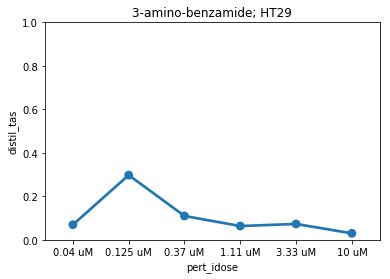

In [ ]:
cp = "3-amino-benzamide"
cell = "HT29"
cp_cell_subset = siginfo[(siginfo["pert_iname"] == cp) &
                         (siginfo["cell_id"] == cell)].dropna(subset=["distil_tas"])

# f, ax = plt.subplots(figsize=(10,7))
sns.pointplot(x="pert_idose",
            y="distil_tas",
            data=cp_cell_subset,
            order=dose_series);
plt.title("{}; {}".format(cp,cell));
plt.ylim(0,1);

We'll want to categorize this low-slope, high TAS range case as "other"

### For our dose-response categories, we'll exclude cases where the fit is poor *except* where we suspect the dose curve is flat (low slope with low TAS range)

## Define heuristics for categorizing

Let's define the following categories:

**dose-responsive (strong)**:
* high slope with good fit
* median TAS >= 0.2

**dose-responsive (subtle)**:
* high slope with good fit
* median TAS < 0.2

**saturated**:
* low slope with low TAS range
* median TAS >= 0.2

**inert**:
* low slope with low TAS range
* median TAS < 0.2

**other**:
* everything else

Now let's categorize according to these heuristics

In [ ]:
cp_cell_metrics["category"] = "other"

cp_cell_metrics.loc[((cp_cell_metrics["lm_slope"] > 0.02) &
                     (cp_cell_metrics["lm_rsquared"] > 0.7) &
                     (cp_cell_metrics["median_tas"] >= 0.2)), "category"] = "dose-responsive-strong"

cp_cell_metrics.loc[((cp_cell_metrics["lm_slope"] > 0.02) &
                     (cp_cell_metrics["lm_rsquared"] > 0.7) &
                     (cp_cell_metrics["median_tas"] < 0.2)), "category"] = "dose-responsive-subtle"

cp_cell_metrics.loc[((cp_cell_metrics["lm_slope"] <= 0.02) &
                     (cp_cell_metrics["range_tas"] < 0.2) &
                     (cp_cell_metrics["median_tas"] >= 0.2)), "category"] = "saturated"

cp_cell_metrics.loc[((cp_cell_metrics["lm_slope"] <= 0.02) &
                     (cp_cell_metrics["range_tas"] < 0.2) &
                     (cp_cell_metrics["median_tas"] < 0.2)), "category"] = "inert"

And let's take a look at the dose-response categories ("other" excluded)

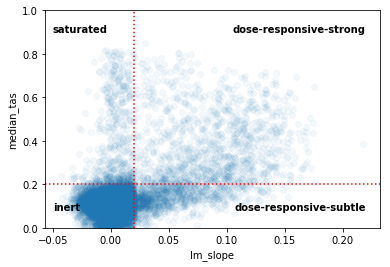

In [ ]:
# f, ax = plt.subplots()
sns.scatterplot(x="lm_slope",
                y="median_tas",
                data=cp_cell_metrics[cp_cell_metrics["category"] != "other"],
                alpha=0.05, edgecolor=None);
plt.axhline(0.2, color="red", linestyle="dotted");
plt.axvline(0.02, color="red", linestyle="dotted");
plt.ylim(0,1.0);

plt.text(0.22, 0.9, "dose-responsive-strong", horizontalalignment="right", weight="semibold");
plt.text(0.22, 0.08, "dose-responsive-subtle", horizontalalignment="right", weight="semibold");
plt.text(-0.05, 0.08, "inert", horizontalalignment="left", weight="semibold");
plt.text(-0.05, 0.9, "saturated", horizontalalignment="left", weight="semibold");

In [ ]:
cats = ["dose-responsive-strong", "dose-responsive-subtle", "saturated", "inert", "other"]
arr = [(cp_cell_metrics["category"] == x).sum() / n_cp_cell_pairs * 100 for x in cats]

6.76% dose-responsive-strong
5.41% dose-responsive=subtle
3.43% saturated
56.66% inert
26.56% other


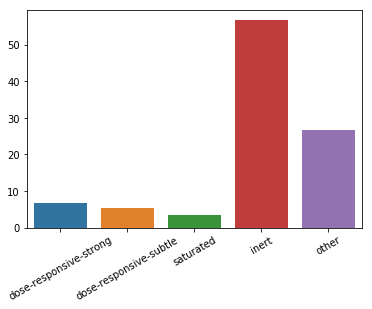

In [ ]:
sns.barplot(x=cats, y=pd.Series(arr))
plt.xticks(rotation=30)

print "{:.2f}% dose-responsive-strong".format((cp_cell_metrics["category"] == "dose-responsive-strong").sum() / n_cp_cell_pairs * 100)
print "{:.2f}% dose-responsive=subtle".format((cp_cell_metrics["category"] == "dose-responsive-subtle").sum() / n_cp_cell_pairs * 100)
print "{:.2f}% saturated".format((cp_cell_metrics["category"] == "saturated").sum() / n_cp_cell_pairs * 100)
print "{:.2f}% inert".format((cp_cell_metrics["category"] == "inert").sum() / n_cp_cell_pairs * 100)
print "{:.2f}% other".format((cp_cell_metrics["category"] == "other").sum() / n_cp_cell_pairs * 100)

# Finding cell-specific dose-response

Let's take a look at how many cases in each category appear per compound

In [105]:
# get categories represented per compound
agg_categorized = cp_cell_metrics.groupby(["cmap_name"])["category"].apply(list).reset_index()
agg_categorized["n_cells_dose-responsive-strong"] = agg_categorized["category"].apply(lambda x: x.count("dose-responsive-strong"))
agg_categorized["n_cells_dose-responsive-subtle"] = agg_categorized["category"].apply(lambda x: x.count("dose-responsive-subtle"))
agg_categorized["n_cells_saturated"] = agg_categorized["category"].apply(lambda x: x.count("saturated"))
agg_categorized["n_cells_inert"] = agg_categorized["category"].apply(lambda x: x.count("inert"))
agg_categorized["n_cells_other"] = agg_categorized["category"].apply(lambda x: x.count("other"))
agg_categorized["n_cells"] = agg_categorized["category"].apply(lambda x: len(x))
agg_categorized = agg_categorized.drop(["category"], axis=1)
agg_categorized.head()

,cmap_name,n_cells_dose-responsive-strong,n_cells_dose-responsive-subtle,n_cells_saturated,n_cells_inert,n_cells_other,n_cells
0,(+)-etimoxir,0,0,0,6,1,7
1,"(+/-)-7-hydroxy-2-(N,N-di-n-propylamino)tetralin",0,0,0,0,1,1
2,(r)-(+)-bornylamine,0,0,0,1,1,2
3,(s)-jq1,2,6,1,0,1,10
4,10-DEBC,0,1,0,3,2,6


We can now look for various combinations of our categories to find interesting differential cell line activity

Let's start with a case where the compound was:
* inert in a majority of cell lines
* saturated or dose-responsive-strong in at least 1 cell line

In [106]:
agg_categorized[(agg_categorized["n_cells_inert"] / agg_categorized["n_cells"] > 1/2) &
                ((agg_categorized["n_cells_saturated"] >= 1) |
                (agg_categorized["n_cells_dose-responsive-strong"] >= 1))]

,cmap_name,n_cells_dose-responsive-strong,n_cells_dose-responsive-subtle,n_cells_saturated,n_cells_inert,n_cells_other,n_cells
36,AGK-2,1,0,2,10,4,17
38,AKT-inhibitor-1-2,1,0,0,9,3,13
51,AT1-SHH-09,0,0,1,6,1,8
89,BRD-A45540146,0,0,1,9,3,13
113,BRD-K06122322,0,0,1,7,0,8
127,BRD-K11267252,1,0,0,8,3,12
133,BRD-K12901964,0,0,1,4,1,6
183,BRD-K24050847,0,0,1,9,1,11
212,BRD-K31455027,0,1,1,5,0,7
221,BRD-K34485477,0,0,1,6,0,7


## A few examples of differential cell line dose-responsiveness

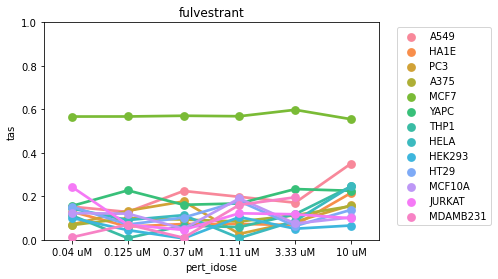

In [110]:
cp = "fulvestrant"
cp_subset = siginfo[siginfo["cmap_name"] == cp].dropna(subset=["tas"])

f, ax = plt.subplots()
sns.pointplot(x="pert_idose", y="tas", hue="cell_iname", data=cp_subset, order=allowed_doses);
plt.title(cp);
plt.legend(bbox_to_anchor=(1.35,1), loc="upper right");
plt.ylim(0,1);


Fulvestrant is an estrogen receptor antagonist, and the two breast cancer lines were the only ones not to be categorized as inert or other. MCF7 was called saturated, and MDAMB231 was called dose-responsive. Interestingly, MCF10A, a non-cancerous breast line was called inert.

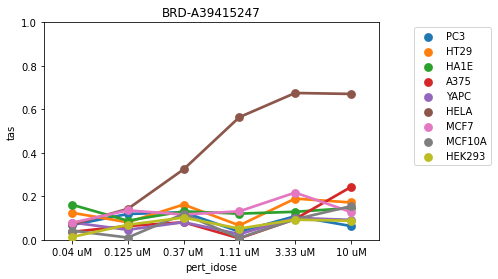

In [116]:
# norethisterone
cp = "BRD-A39415247"
cp_subset = siginfo[siginfo["cmap_name"] == cp].dropna(subset=["tas"])

f, ax = plt.subplots()
sns.pointplot(x="pert_idose", y="tas", hue="cell_iname", data=cp_subset, order=allowed_doses);
plt.title(cp);
plt.legend(bbox_to_anchor=(1.35,1), loc="upper right");
plt.ylim(0,1);


Norethisterone is 